### Import

In [1]:
# Libraries
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import matplotlib as mpl

# Files
from vehicle import *
from simulate import *
from mpc import *
from global_path_planning import *
from obstacles import *

matplotlib.rcParams['animation.embed_limit'] = 2**128


### Simulation Input Parameters

In [2]:
#### MPC Properties
dt = 0.075                  # Time step [s]
N = 17                # Time Horizon

####  Simulation/Problem Parameters
pos_constraints = [0, 20, 0, 60, 0, 20]         # Position Constraints [m]:    [x_min, x_max, y_min, y_max, z_min, z_max	]
x_init = [10, 2, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0]          # Initial State: [x, y, z, x_dot, y_dot, z_dot]
x_target_last = [10, 48, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0]      # Target State: [x, y, z, x_dot, y_dot, z_dot]
T = 35                             # Simulation time [s]


# Speed limit
speed_limit = 10

# Roll and Pitch limit
angle_limit = 90

# Acceleration limit
acc_limit_x = 20
acc_limit_y = 20
acc_limit_z = 20

       # Position Constraints [m]:    [x_min, x_max, y_min, y_max, z_min, z_max	]
vel_constraints = [-speed_limit, speed_limit, -speed_limit, speed_limit, -speed_limit, speed_limit]         # Velocity Constraints [m/s]:  [x_min, x_max, y_min, y_max, z_min, z_max]
ang_constraints = [-angle_limit, angle_limit, -angle_limit, angle_limit, -360, 360]         # Angular Velocity Constraints [rad/s]:  [x_min, x_max, y_min, y_max, z_min, z_max]
acc_constraints = [-acc_limit_x, acc_limit_x, -acc_limit_y, acc_limit_y, -acc_limit_z, acc_limit_z]  
max_rad_per_s = 3000

#### Obstacles
static_cost = 45
dynamic_cost = 145

#### Waypoint Radius Threshold
waypoint_radius = 3


In [3]:
#### Obstacle Definition and Initialization

## Define Obstacles
# V_obstacles = [[10, 20, 4], [18, 30, 3]]
V_obstacles = [[10, 30, 2], [17, 23, 3], [7, 20, 4], [14, 37, 3], [1, 28, 4]]
V_move_obstacles = [[5, 30, 1, 0, 1.5, 12], [12, 45, 0, -1, 2, 30], [6, 15, 1, 0, 3, 8]] # [center_x, center_y, vel_x, vel_y, radius]
#V_move_obstacles = []
H_obstacles = [[10, 10, 3]]         # [center_y, center_z, radius]
H_move_obstacles = []  # [center_y, center_z, vel_y, vel_z, radius]

## Initialize Obstacles
obstacles = init_obstacles(V_obstacles, V_move_obstacles, H_obstacles, H_move_obstacles, static_cost, dynamic_cost)

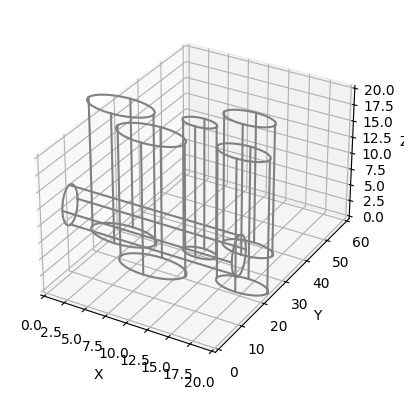

IntProgress(value=0, max=500)

Goal found


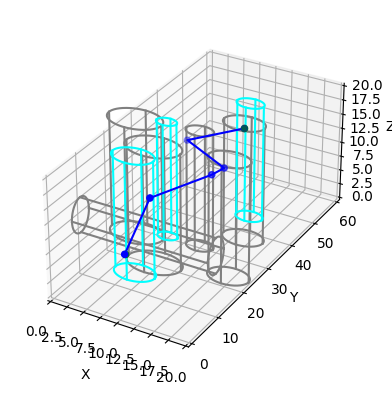

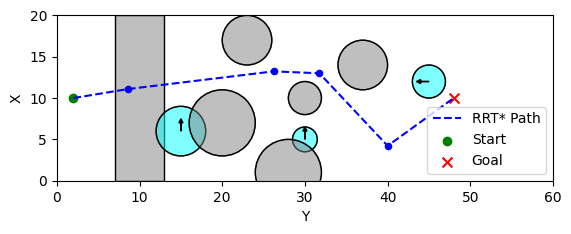

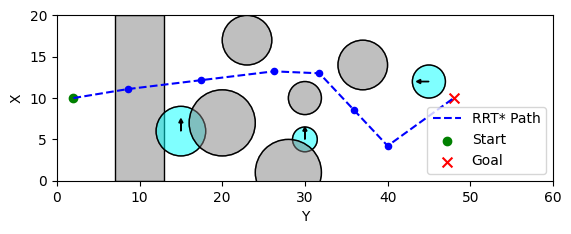

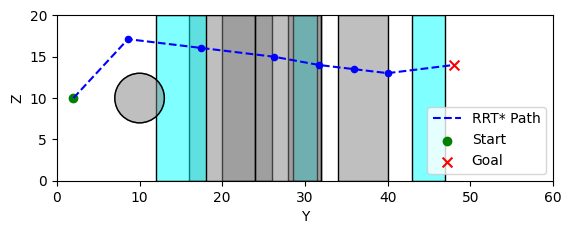

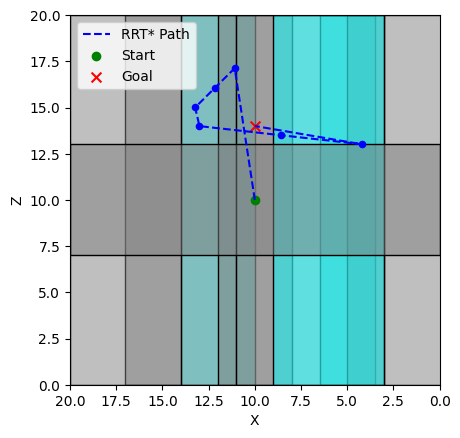

In [4]:
# Create Static World
World = World_3D([pos_constraints[0], pos_constraints[1]], [pos_constraints[2], pos_constraints[3]], [pos_constraints[4], pos_constraints[5]], obstacles, obstacle_margin=1)
World.plot3d()

# Run RRT* to find a path
path_rrt = rrt_star(World, x_init[:3], x_target_last[:3], radius=25, max_iter=500)
World.plot3d(path_rrt, plot_moving_obstacles=True)
World.plot2d_xy(path_rrt, plot_moving_obstacles=True)

path_rrt = path_rrt.get_subdivided_path(12)
World.plot2d_xy(path_rrt, plot_moving_obstacles=True)
World.plot2d_yz(path_rrt, plot_moving_obstacles=True)
World.plot2d_xz(path_rrt, plot_moving_obstacles=True)


In [5]:
# %%capture
# Setup Controller and Simulate
vehicle = Quadrotor(dt)
controller = lambda x_init, current_wp, last_input, last_plan : mpc_control(vehicle, N, x_init, current_wp, pos_constraints, vel_constraints, acc_constraints, ang_constraints, max_rad_per_s, last_plan, obstacles)
states, inputs, plans, timesteps, target_state = simulate(dt, T, x_init, x_target_last, N, controller, World, path_rrt, waypoint_radius, num_states=12, num_inputs=4)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)   3.41ms ( 74.24us)        46
       nlp_g  |        0 (       0)   8.27ms (179.80us)        46
  nlp_grad_f  |        0 (       0)   4.50ms ( 97.74us)        46
  nlp_hess_l  |  49.00ms (  1.11ms)  71.49ms (  1.62ms)        44
   nlp_jac_g  |  34.00ms (739.13us)  24.96ms (542.57us)        46
       total  | 347.00ms (347.00ms) 346.46ms (346.46ms)         1
Optimal cost: 5996.933519273661
Progress: 0/467
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)  

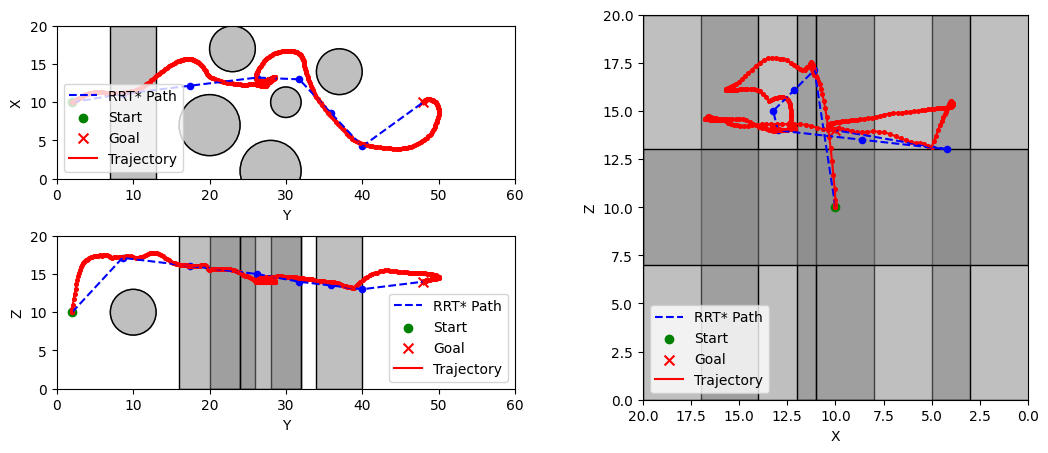

In [6]:
#plot the path with 2 subplots
fig = plt.figure(figsize=(13, 5))

gs = gridspec.GridSpec(2, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[:, 1])

World.plot2d_xy_ax(ax1, path_rrt, states)
World.plot2d_yz_ax(ax2, path_rrt, states)
World.plot2d_xz_ax(ax3, path_rrt, states)
#World.plot3d_ax(ax4, path_rrt, states)

plt.show()
                   

In [ ]:
## Plot Simulation
obstacles_plotting = init_obstacles(V_obstacles, V_move_obstacles, H_obstacles, H_move_obstacles, static_cost, dynamic_cost)
World_plotting = World_3D([pos_constraints[0], pos_constraints[1]], [pos_constraints[2], pos_constraints[3]], [pos_constraints[4], pos_constraints[5]], obstacles_plotting, obstacle_margin=1)

def update(frame):
    global ax
    # Clear previous frame
    ax.cla()

    # Plot Path for current state
    ax.scatter(plans[0][:, frame], plans[1][:, frame], plans[2][:, frame], c='g', s=20, label = "Planned Trajectory")

    # Plot current state
    ax.scatter(target_state[0][frame], target_state[1][frame], target_state[2][frame], s=40, color='b', label = "Target Point")

    ax.scatter(states[0][frame], states[1][frame], states[2][frame], s=40, color='red', label = "Drone")
    
    World_plotting.update(dt)

    # Plot Environment
    World_plotting.plot3d_ax(ax, plot_moving_obstacles=True)

    ax.legend()
    ax.set_title(f'Time Step {frame + 1}/{len(states[1])}')  # Set title for each frame




# Create the animation
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ani = FuncAnimation(fig, update, frames=len(states[1]) - 1, interval=int(dt*1000))
# Display the animation within the Jupyter Notebook using HTML
HTML(ani.to_jshtml())


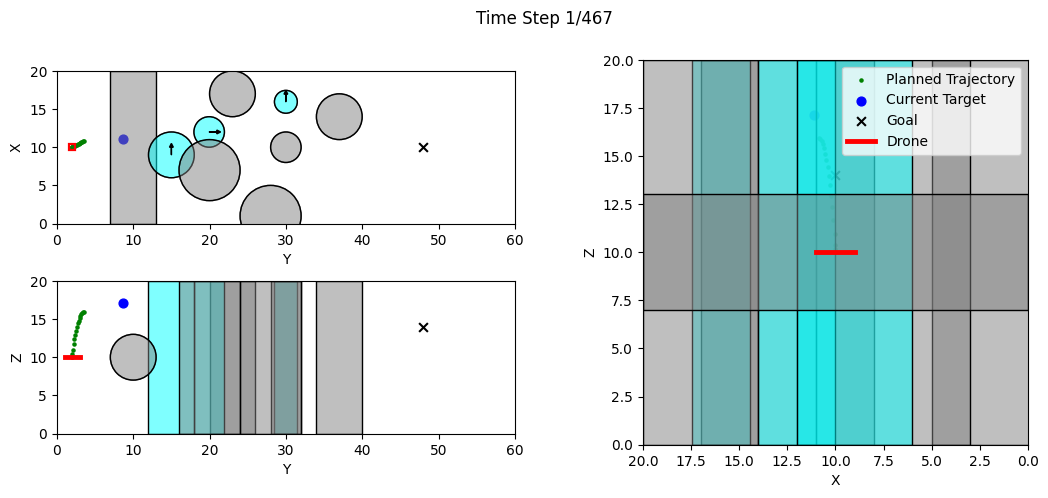

In [7]:
## Plot Simulation
obstacles_plotting2 = init_obstacles(V_obstacles, V_move_obstacles, H_obstacles, H_move_obstacles, static_cost, dynamic_cost)
World_plotting2 = World_3D([pos_constraints[0], pos_constraints[1]], [pos_constraints[2], pos_constraints[3]], [pos_constraints[4], pos_constraints[5]], obstacles_plotting2, obstacle_margin=1)

def update(frame):
    global ax1, ax2, ax3
    # Clear previous frame
    ax1.cla()
    ax2.cla()
    ax3.cla()

    # Plot Path for current state
    ax1.scatter(plans[1][:, frame], plans[0][:, frame], c='g', s=5, label = "Planned Trajectory")
    ax2.scatter(plans[1][:, frame], plans[2][:, frame], c='g', s=5, label = "Planned Trajectory")
    ax3.scatter(plans[0][:, frame], plans[2][:, frame], c='g', s=5, label = "Planned Trajectory")
    

    # Plot current target
    ax1.scatter(target_state[1][frame], target_state[0][frame], s=40, color='b', label = "Current Target")
    ax2.scatter(target_state[1][frame], target_state[2][frame], s=40, color='b', label = "Current Target")
    ax3.scatter(target_state[0][frame], target_state[2][frame], s=40, color='b', label = "Current Target")
    
    #plot end goal
    ax1.scatter(x_target_last[1], x_target_last[0], s=40, color='black', marker='x', label = "Goal")
    ax2.scatter(x_target_last[1], x_target_last[2], s=40, color='black', marker='x', label = "Goal")
    ax3.scatter(x_target_last[0], x_target_last[2], s=40, color='black', marker='x', label = "Goal")
    
    #plot attitude of drone as thin red line
    linelength = 1
    linewidth = 3.5
    
    #draw a rectangle rotated correctly
    #r2 = patches.Rectangle((0,0), 20, 40, color="red",  alpha=0.50)
    rectsize = linelength * .75
    rect = patches.Rectangle((states[1][frame] - rectsize/2, states[0][frame] - rectsize/2), rectsize, rectsize, fill=False, edgecolor='red', linewidth=1.6, label = 'Drone')
    t = mpl.transforms.Affine2D().rotate_around(states[1][frame], states[0][frame], states[5][frame]) + ax1.transData
    rect.set_transform(t)
    ax1.add_patch(rect)
    
    
    c = np.cos(states[3][frame])
    s = np.sin(states[3][frame])
    ax2.plot([states[1][frame] - linelength * c, states[1][frame] + linelength * c], [states[2][frame] - linelength * s, states[2][frame] + linelength * s], color='red', linewidth=linewidth, label = 'Drone')
    c = np.cos(-states[4][frame])
    s = np.sin(-states[4][frame])
    ax3.plot([states[0][frame] - linelength * c, states[0][frame] + linelength * c], [states[2][frame] - linelength * s, states[2][frame] + linelength * s], color='red', linewidth=linewidth, label = 'Drone')
    #ax1.scatter(states[1][frame], states[0][frame], s=40, color='red', label = "Drone")    
    #ax2.scatter(states[1][frame], states[2][frame], s=40, color='red', label = "Drone")
    #ax3.scatter(states[0][frame], states[2][frame], s=40, color='red', label = "Drone")
    
    
    World_plotting2.update(dt)

    # Plot Environment
    World_plotting2.plot2d_xy_ax(ax1, plot_moving_obstacles=True, show_legend=False)    
    World_plotting2.plot2d_yz_ax(ax2, plot_moving_obstacles=True, show_legend=False)
    World_plotting2.plot2d_xz_ax(ax3, plot_moving_obstacles=True, show_legend=True)

    fig.suptitle(f'Time Step {frame + 1}/{len(states[1])}')




# Create the animation
fig = plt.figure(figsize=(13, 5))

gs = gridspec.GridSpec(2, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[:, 1])

#update(0)
#plt.show()

ani = FuncAnimation(fig, update, frames=len(states[1]) - 1, interval=int(dt*1000))
# Display the animation within the Jupyter Notebook using HTML
#HTML(ani.to_jshtml())

ani.save('animation.mp4', writer='ffmpeg')


In [ ]:
#Evaluation metrics
from evaluation_metrics import *

print("states3-6 shape",states[3:6].T.shape)
# 1. Trajectory Smoothness
plot_trajectory_smoothness(velocities=states[3:6].T,
                           orientation_rates=states[6:9].T,
                           num_timesteps=len(timesteps),
                           duration_sec=T,
                           dt=dt)
# 2. Control Effort
print("inputs T shape:",inputs.T.shape)
print("inputs0",inputs.T[0])
plot_control_effort(control_inputs=inputs.T,
                    duration_sec=T,
                    num_timesteps =len(timesteps))